In [1]:
# ignore warnings for better clarity (may not be the best thing to do)...
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
import keras
from keras.preprocessing import sequence 
from keras.models import Sequential 
from keras.layers import Dense, Embedding 
from keras.layers import LSTM 
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
print("tensorflow version %s (should be at least 0.12.1)" % tf.__version__)
print("keras version %s (should be at least 2.0.7)" % keras.__version__)

tensorflow version 1.13.1 (should be at least 0.12.1)
keras version 2.2.4 (should be at least 2.0.7)


## <font color=darkred> Data exploration </font>

In [4]:
# load dataset
raw_data = pd.read_csv('./pollution.csv', header=0, index_col=0)
values = raw_data.values

This dataset provides hourly weather conditions and pollution levels for  five years at the US embassy in Beijing, China.

The complete feature list in the raw data is as follows:

``No``: row number

``year``: year of data in this row

``month``: month of data in this row

``day``: day of data in this row

``hour``: hour of data in this row

``pm2.5``: PM2.5 concentration i.e. pollution level

``DEWP``: Dew Point

``TEMP``: Temperature

``PRES``: Pressure

``cbwd``: Combined wind direction

``Iws``: Cumulated wind speed

``Is``: Cumulated hours of snow

``Ir``: Cumulated hours of rain

In [5]:
raw_data.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


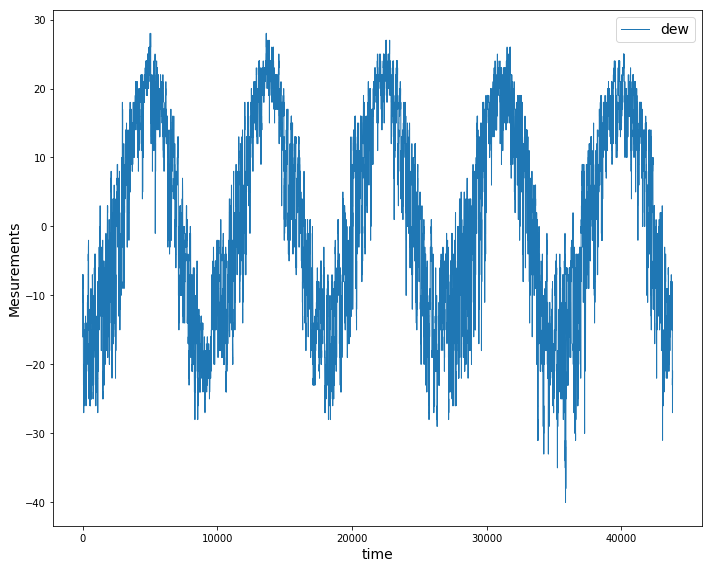

In [6]:
plt.figure(figsize=(10, 8))
plt.plot(values[:, 1], lw=1, label=raw_data.columns[1])
plt.legend(fontsize=14)
plt.xlabel('time', fontsize=14)
plt.ylabel('Mesurements', fontsize=14)
plt.tight_layout()
plt.show()

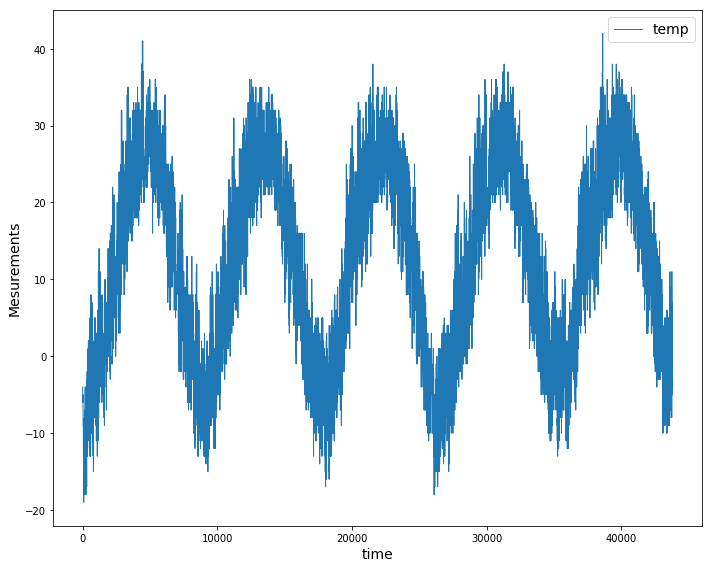

In [7]:
plt.figure(figsize=(10, 8))
plt.plot(values[:, 2], lw=1, label=raw_data.columns[2])
plt.legend(fontsize=14)
plt.xlabel('time', fontsize=14)
plt.ylabel('Mesurements', fontsize=14)
plt.tight_layout()
plt.show()

**Comments: ** On these two graphics, we can see the fact that we have 5 years of data recording. Indeed there is a pattern which approximatively repeat itself after around 10000 times steps (we guess it is 8790, the number of hours in a year). Thus it's obvious that these former data are hugely linked to the period of the year which is logical as they are climate datas.

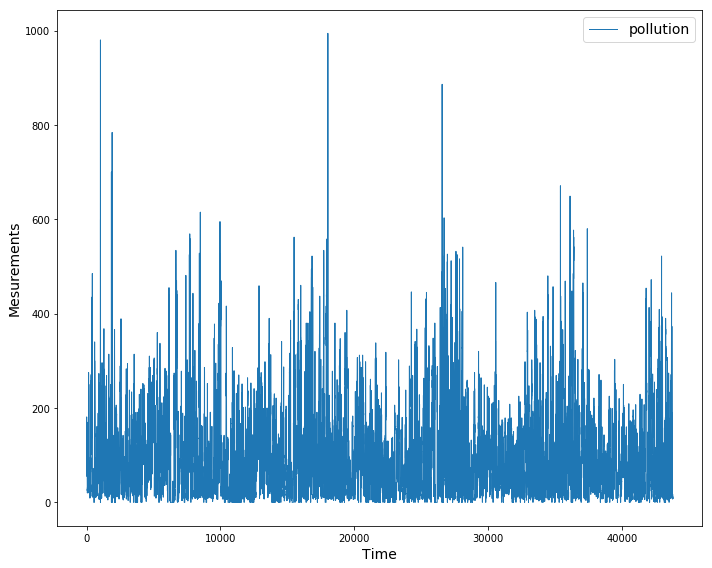

In [8]:
plt.figure(figsize=(10, 8))
plt.plot(values[:, 0], lw=1, label=raw_data.columns[0])
plt.legend(fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Mesurements', fontsize=14)
plt.tight_layout()
plt.show()

**Comments: ** This is supposed to reprensent the pollution level. Even if it seems to exist a pattern from a year to another, it is not obvious. There is a lot of variability in pollution level whithin a year and from a year to another. Therefore, this make us think that this variable depends on several others and not only on the time.

**Questions**

Display the pollution level as a function of time.

Use the ``heatmap`` function to display the correlation of the data.

Display boxplots of the pollution values as a function of other variables values
(This may help to detect useless features for prediction).


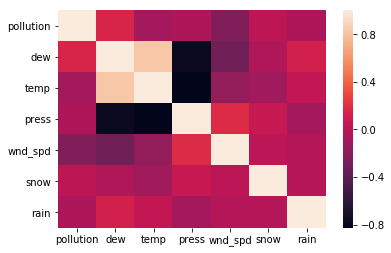

,pollution,dew,temp,press,wnd_spd,snow,rain
pollution,1.000000,0.157585,-0.090798,-0.045544,-0.234362,0.022226,-0.049045
dew,0.157585,1.000000,0.824432,-0.778737,-0.296720,-0.034484,0.125053
temp,-0.090798,0.824432,1.000000,-0.827205,-0.154902,-0.092726,0.049037
press,-0.045544,-0.778737,-0.827205,1.000000,0.185380,0.069031,-0.079840
wnd_spd,-0.234362,-0.296720,-0.154902,0.185380,1.000000,0.021876,-0.010137


In [9]:
import seaborn as sns
corr = raw_data.corr()
heat_m = sns.heatmap(corr)
plt.show()
corr.head()

***Comments: *** We notice that some variables variables are strongly correlated. For exemple temperature and dew or temperature and pression. Therefore, knowing only one of these would be enough to train a model as the somehow bring they same informations.

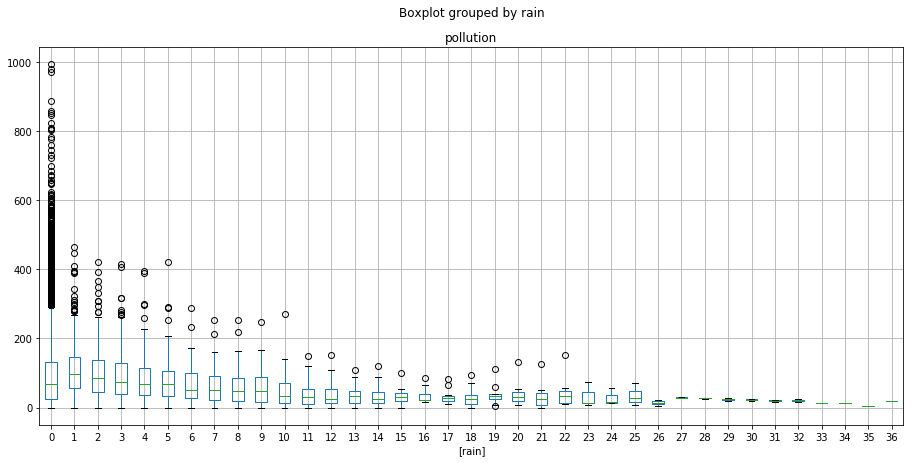

In [10]:
raw_data.boxplot('pollution', by=['rain'],figsize=(15,7))
plt.show()

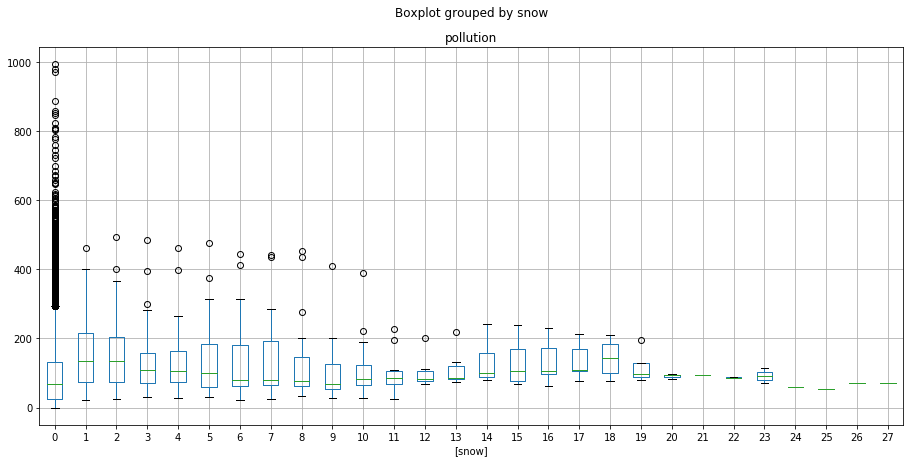

In [11]:
raw_data.boxplot('pollution', by=['snow'],figsize=(15,7))
plt.show()

***Comments: *** On the two boxplots above we can see that the snow and rain seem to have the same influence on pollution level. Indeed, the less there is rain or snow the more there are outlayers in pollution level values. The peaks of pollution are reached when there is no rain and snow. 

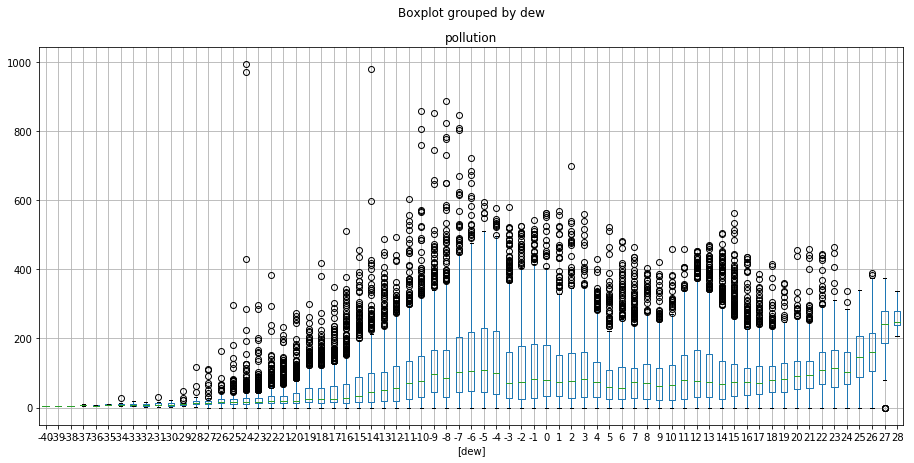

In [12]:
raw_data.boxplot('pollution', by=['dew'],figsize=(15,7))
plt.show()

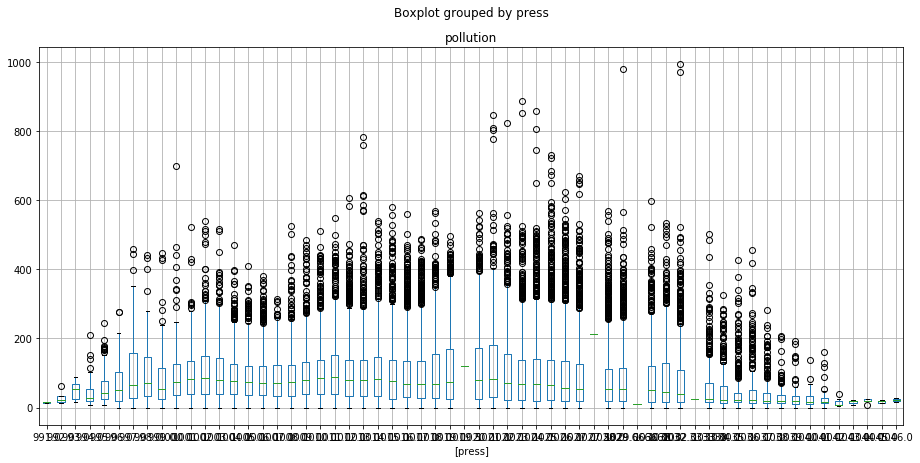

In [13]:
raw_data.boxplot('pollution', by=['press'],figsize=(15,7))
plt.show()

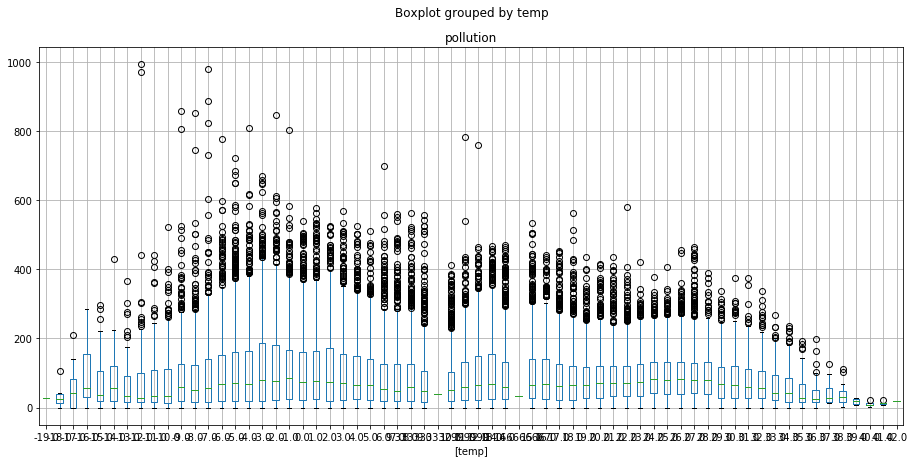

In [14]:
raw_data.boxplot('pollution', by=['temp'],figsize=(15,7))
plt.show()

***Comments: *** On the previous 3 boxplots it's hard to assess the impact of temperature, dew and pressure on pollution  level as the characteristic  values are slightly the same and so is the amount of outlayers except for few values.

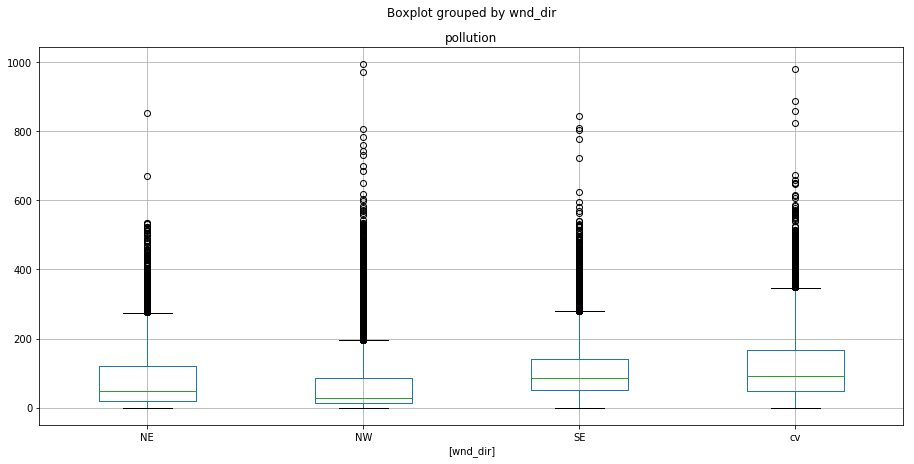

In [15]:
raw_data.boxplot('pollution', by=['wnd_dir'],figsize=(15,7))
plt.show()

***Comments: *** Logically, it appears that the wind direction doesn't really have an influence on pollution level as the medians and the quartiles are not significatively different and the amount of outlayers is huge for each.

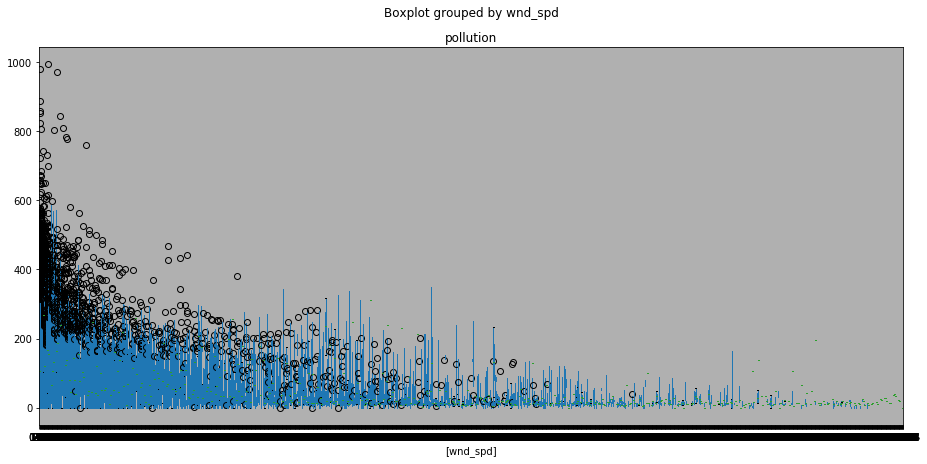

In [16]:
raw_data.boxplot('pollution', by=['wnd_spd'],figsize=(15,7))
plt.show()

***Comments: *** What we see is that the more there is wind (high speed) the less the polution is high. The peaks of pollution are reached where the wind speed is low. It is logical since the wind move less "polluting" particles under those conditions.

## <font color=darkred> Pre-processing </font>

Pre-processing from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

Design which data to use as inputs and which as outputs.

This function gets rid of NaN values.

It may be skipped during the first read. The only crucial feature is the ``n_in`` parameters which states the number of previous time steps to consider in the input data.

The objective of this project is to predict the pollution level $y_t$ at time $t$ from previous observations.
Simple recurrent neural networks and Long Short-Term memory will be considered. At each time step the estimate $\hat{y}_t$ is obtained using a hidden state $h_{t-1}$ computed on the fly and input data $x_t$ at time $t$. 

The function ``build_dataset`` provives the values of $y_t$ in the last column and the values of the input $x_t$ in all the other columns.

If $n_{in} = 0$, $x_t$ is made of all measurements at time $t$ except the pollution level.


If $n_{in} = 1$, $x_t$ is made of all measurements at time $t$ except the pollution level and of all measurements at time  $t-1$.

If $n_{in} = 2$, $x_t$ is made of all measurements at time $t$ except the pollution level and of all measurements at time  $t-1$ and time $t-2$.

In [17]:
def build_dataset(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))   #deletes the last i rows of the dataset(as the shifting is on the rows)
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [18]:
# integer encode direction
encoder = preprocessing.LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4]) #transform the wind direction into integer
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# parameter to design how many time steps to consider in the input data
time_lag = 1
processed_data = build_dataset(scaled, time_lag, 1)
processed_data.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0


In [114]:
# split into train and test sets
values = processed_data.values
values1=values.copy()   #make a copy of values where the last column is set as the pollution level we want to predict
values1[:,-1],values1[:,-8]=values[:,-8],values[:,-1 ]

# number of years to use for training
nb_years = 4
n_train_hours = nb_years*365 * 24

train = values1[:n_train_hours, :]
test = values1[n_train_hours:, :]

# split into input and outputs: 
# train_X contains the values of x_t i.e. all columns of the dataset except the last one
# train_y contains the associated values of y_t i.e. the last column of the dataset
train_X, train_y = train[:, :-8], train[:, -1]
test_X, test_y = test[:, :-8], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [115]:
print('x_train shape:', train_X.shape)
print('x_test shape:', test_X.shape)
print('y_train shape:', train_y.shape)
print('y_test shape:', test_y.shape)

x_train shape: (35040, 1, 8)
x_test shape: (8759, 1, 8)
y_train shape: (35040,)
y_test shape: (8759,)


In [21]:
print(train_X.shape[0], 'train samples')
print(test_X.shape[0], 'test samples')

35040 train samples
8759 test samples


In [22]:
input_shape = (train_X.shape[1], train_X.shape[2])
input_shape

(1, 8)

## <font color=darkred> Feed Forward Neural Network </font>

In [23]:
from random import randint
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import activations
import numpy as np
import matplotlib.pyplot as plt

**Question**

Define a FFNN model with one hidden layer

In [24]:
model_ffnn = Sequential()

model_ffnn.add(Flatten(input_shape=input_shape))
model_ffnn.add(Dense(128, activation='relu'))
model_ffnn.add(Dense(1, activation='linear'))

model_ffnn.compile(
    loss='mae',
    optimizer=keras.optimizers.Adagrad(),
    metrics=['mean_squared_error']
)

model_ffnn.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1152      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [25]:
batch_size = 64
epochs = 50
history = model_ffnn.fit(train_X, train_y,
                         batch_size=batch_size,
                         epochs=epochs,
                         verbose=1,
                         validation_data=(test_X, test_y))

Instructions for updating:
Use tf.cast instead.
Train on 35040 samples, validate on 8759 samples
Epoch 1/50
35040/35040 [==============================] - 3s 84us/step - loss: 0.0200 - mean_squared_error: 0.0013 - val_loss: 0.0164 - val_mean_squared_error: 7.1690e-04
Epoch 2/50
35040/35040 [==============================] - 2s 47us/step - loss: 0.0141 - mean_squared_error: 7.9220e-04 - val_loss: 0.0125 - val_mean_squared_error: 5.9055e-04
Epoch 3/50
35040/35040 [==============================] - 2s 45us/step - loss: 0.0138 - mean_squared_error: 7.8352e-04 - val_loss: 0.0136 - val_mean_squared_error: 6.1626e-04
Epoch 4/50
35040/35040 [==============================] - 2s 49us/step - loss: 0.0137 - mean_squared_error: 7.7802e-04 - val_loss: 0.0125 - val_mean_squared_error: 5.9224e-04
Epoch 5/50
35040/35040 [==============================] - 1s 42us/step - loss: 0.0136 - mean_squared_error: 7.7700e-04 - val_loss: 0.0132 - val_mean_squared_error: 6.0825e-04
Epoch 6/50
35040/35040 [========

Epoch 46/50
35040/35040 [==============================] - 1s 40us/step - loss: 0.0132 - mean_squared_error: 7.6369e-04 - val_loss: 0.0124 - val_mean_squared_error: 5.8869e-04
Epoch 47/50
35040/35040 [==============================] - 1s 40us/step - loss: 0.0132 - mean_squared_error: 7.6391e-04 - val_loss: 0.0124 - val_mean_squared_error: 5.8440e-04
Epoch 48/50
35040/35040 [==============================] - 1s 40us/step - loss: 0.0132 - mean_squared_error: 7.6342e-04 - val_loss: 0.0123 - val_mean_squared_error: 5.8379e-04
Epoch 49/50
35040/35040 [==============================] - 1s 38us/step - loss: 0.0132 - mean_squared_error: 7.6358e-04 - val_loss: 0.0125 - val_mean_squared_error: 5.8739e-04
Epoch 50/50
35040/35040 [==============================] - 1s 38us/step - loss: 0.0132 - mean_squared_error: 7.6398e-04 - val_loss: 0.0123 - val_mean_squared_error: 5.8396e-04


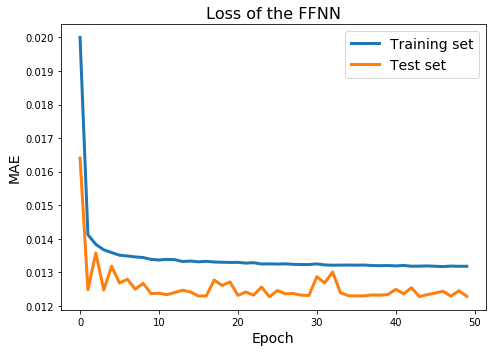

In [28]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['loss'], lw=3, label='Training set')
plt.plot(history.epoch, history.history['val_loss'], lw=3, label='Test set')
plt.legend(fontsize=14)
plt.title('Loss of the FFNN', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('MAE', fontsize=14)
plt.tight_layout()
plt.show()

***Comments: *** After properly building a data set, we train a FFNN on them. This graphic shows that for the training set the Mean Absolute Error(MAE) converges fastly (in term of number of epochs needed) to a value around 0.0135. The MAE on the testing set is similarly fast and even better. Indeed, it plateaus for a value around 0.0125 even if sometimes we have a "significant" variation from an epoch to another. These variations could be highlighting the randomness of the predictions.

## <font color=darkred> Recurrent Neural Networks</font>

At time $t$ the hidden state of the network is computed as follows:

$h_t = \sigma_h(W_x\,{x_t} + W_h\,{h_{t-1}} + b_h)$, where $\sigma_h$ is a nonlinear activation function, e.g. $\mathrm{tanh}$, $x_t$ is the input at time $t$ and $h_{t-1}$ is the hidden state at the previous time step.

$W_x$, $b_h$ and $W_h$ are the unknown parameters of the state update.

The predicted output is:

$\widehat{y}_t = \sigma_y(W_y\,{h_t} + b_y)\,,$

where $\sigma_y$ is the output activation function and $W_y$ and $b_y$ are the unknown parameters of the prediction step.

**Question**

Define a RNN model with one hidden layer ``SimpleRNN``

In [29]:
from keras.layers.recurrent import SimpleRNN
model_rnn = Sequential()
model_rnn.add(SimpleRNN(32,input_shape=input_shape))  
model_rnn.add(Dense(1, activation='linear'))

model_rnn.compile(loss='mae', optimizer='adam')

model_rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 32)                1312      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,345
Trainable params: 1,345
Non-trainable params: 0
_________________________________________________________________


In [30]:
batch_size = 64
epochs = 50
history = model_rnn.fit(train_X, train_y, 
                        epochs = epochs,
                        batch_size = batch_size, 
                        validation_data=(test_X, test_y),
                        verbose=1)

Train on 35040 samples, validate on 8759 samples
Epoch 1/50
35040/35040 [==============================] - 4s 106us/step - loss: 0.0508 - val_loss: 0.0128
Epoch 2/50
35040/35040 [==============================] - 2s 54us/step - loss: 0.0140 - val_loss: 0.0126
Epoch 3/50
35040/35040 [==============================] - 2s 48us/step - loss: 0.0141 - val_loss: 0.0127
Epoch 4/50
35040/35040 [==============================] - 2s 47us/step - loss: 0.0141 - val_loss: 0.0141
Epoch 5/50
35040/35040 [==============================] - 2s 55us/step - loss: 0.0141 - val_loss: 0.0136
Epoch 6/50
35040/35040 [==============================] - 2s 49us/step - loss: 0.0140 - val_loss: 0.0126
Epoch 7/50
35040/35040 [==============================] - 2s 47us/step - loss: 0.0141 - val_loss: 0.0138
Epoch 8/50
35040/35040 [==============================] - 2s 48us/step - loss: 0.0140 - val_loss: 0.0132
Epoch 9/50
35040/35040 [==============================] - 2s 48us/step - loss: 0.0138 - val_loss: 0.0130
Epoch

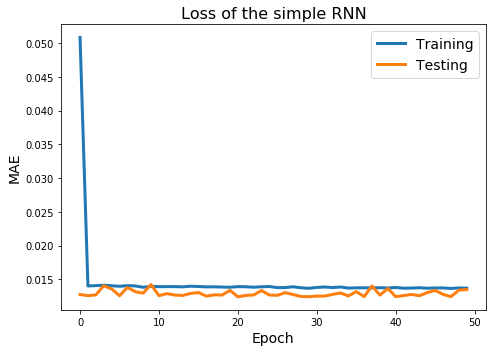

In [31]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['loss'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_loss'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Loss of the simple RNN', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('MAE', fontsize=14)
plt.tight_layout()
plt.show()

***Comments: *** Now we train a RNN on the data set. What we first notice is that it converges faster than the FFNN on training set and even more on testing set where the first MAE is close to the best. However the limit values reached are not as good as those of FFNN since they are around 0.015. At first it surprising because we slighly have more parameters here than in MLP, but perahps as the dataset is "simple" and not huge, the basic FFNN is enough.

## <font color=darkred> Long Short-Term memory </font>

The LSTM cell is a more complex recurrent neural network. It contains three gates, input, forget, output gates and a memory cell i.e. several hidden transformations to process the hidden state and the input. 

The first transforms at time $t$ are: 

$i_t = \sigma ( W_i [h_{t-1}, x_t] + b_i)$, $f_t = \sigma ( W_f [h_{t-1},x_t] + b_f)$, $o_t = \sigma ( W_o [h_{t-1},x_t] + b_o)$,

where $W_i, W_f, W_o$, $b_i$, $b_f$ and $b_o$ are the unknown parameters (applied to the concatenation of $h_{t-1}$ (hidden state vector) and $x_t$ (input vector)).

The previous hidden state $h_{t-1}$ and the current input $x_t$ are used to compute the a candidate $g_t$:

$g_t = \mathrm{tanh}( W_g [h_{t-1}, x_t] + b_g)\,.$

The cell memory $c_t$, is updated as:

$c_t = c_{t-1} \circ f_t + g_t \circ i_t\,,$

where $c_{t-1}$ is the previous memory, and $\circ$ refers to element-wise multiplication.

The output, $h_t$, is computed as

$h_t = \mathrm{tanh}(c_t) \circ o\,.$

The predicted output is:

$\widehat{y}_t = \sigma_y(W_y\,{h_t} + b_y)\,,$

where $\sigma_y$ is the output activation function and $W_y$ and $b_y$is the unknown parameter of the prediction step.

**Question**

Define a LSTM model with one hidden layer

In [32]:
from keras.layers.recurrent import LSTM

In [33]:
model_LSTM = Sequential()

model_LSTM.add(LSTM(32,input_shape=input_shape))

model_LSTM.add(Dense(1, activation="linear"))
model_LSTM.compile(loss='mae', optimizer='adam')
model_LSTM.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5248      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 5,281
Trainable params: 5,281
Non-trainable params: 0
_________________________________________________________________


In [34]:
batch_size = 64
epochs = 50
history = model_LSTM.fit(train_X, train_y, 
                         epochs = epochs, 
                         batch_size = batch_size, 
                         validation_data=(test_X, test_y), 
                         verbose=1)

Train on 35040 samples, validate on 8759 samples
Epoch 1/50
35040/35040 [==============================] - 6s 183us/step - loss: 0.0314 - val_loss: 0.0127
Epoch 2/50
35040/35040 [==============================] - 3s 96us/step - loss: 0.0139 - val_loss: 0.0125
Epoch 3/50
35040/35040 [==============================] - 3s 93us/step - loss: 0.0138 - val_loss: 0.0138
Epoch 4/50
35040/35040 [==============================] - 3s 94us/step - loss: 0.0137 - val_loss: 0.0126
Epoch 5/50
35040/35040 [==============================] - 3s 94us/step - loss: 0.0137 - val_loss: 0.0128
Epoch 6/50
35040/35040 [==============================] - 3s 98us/step - loss: 0.0136 - val_loss: 0.0125
Epoch 7/50
35040/35040 [==============================] - 3s 93us/step - loss: 0.0136 - val_loss: 0.0125
Epoch 8/50
35040/35040 [==============================] - 3s 94us/step - loss: 0.0136 - val_loss: 0.0127
Epoch 9/50
35040/35040 [==============================] - 4s 101us/step - loss: 0.0137 - val_loss: 0.0124
Epoc

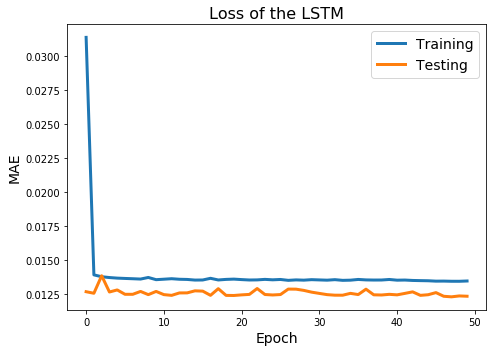

In [35]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['loss'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_loss'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Loss of the LSTM', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('MAE', fontsize=14)
plt.tight_layout()
plt.show()

***Comments: *** The LTSM model seems to be more efficient than the RNN with a training MAE aroung 0.0138 and a testing MAE around 0.0125. Since LTSM model has 4 times more parameters than a RNN model, this is logical. However, this performance is not much better than the FFNN's (which also have 4 times less parameters) in terms of MAE. Indeed the limits values appear to be the same on testing set. As the scales are different between the two graphics, it's hard to compare the variations of MAE for these two models but they exist in both.

**Questions**

Use a cross-validation to select the best LSTM and best RNN networks (with respect to the dimension of the hidden state) dimension.

Analyze the impact of the lag in the input sequence (i.e. if $x_t$ contains the features at times $t-1$, $t-2$, $t-3$) by using the function ``build_dataset`` with another parameter ``n_in``.

Analyze the sensitiviy of the LSTM with respect to initialization (by training several independent LSTM models).

Use the predict function to predict the observations $y$ associated with the input data in ``test_X``. Display these predictions with the true pollution level in ``y_test``. Compute the associated mean square error. 

In [167]:
def new_rnn(hdim, in_shape):
    model_rnn = Sequential()
    model_rnn.add(SimpleRNN(hdim,input_shape=in_shape))  
    model_rnn.add(Dense(1, activation='linear'))

    model_rnn.compile(loss='mae', optimizer='adam')
    return model_rnn

In [239]:
def new_lstm(hdim,in_shape=input_shape):
    model_LSTM = Sequential()

    model_LSTM.add(LSTM(hdim,input_shape=in_shape))

    model_LSTM.add(Dense(1, activation="linear"))
    model_LSTM.compile(loss='mae', optimizer='adam')
    model_LSTM.summary()
    return model_LSTM

In [38]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [41]:
#here we run a cross-validation on the hidden layer dimension for a rnn

parameters = {'hdim': [32,64,128,256],
              }

keras_model = KerasRegressor(build_fn = new_rnn,epochs=50)

clf1= GridSearchCV(keras_model, parameters, cv = 3)
clf1.fit(train_X, train_y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 32)                1312      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,345
Trainable params: 1,345
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
23360/23360 [==============================] - 4s 171us/step - loss: 0.0206
Epoch 2/50
23360/23360 [==============================] - 2s 103us/step - loss: 0.0144
Epoch 3/50
23360/23360 [==============================] - 2s 101us/step - loss: 0.0142
Epoch 4/50
23360/23360 [==============================] - 3s 110us/step - loss: 0.0142
Epoch 5/50
23360/23360 [==============================] - 2s 88us/step - loss: 0.0141
Epoch 6/50
23360/23360 [==============================] - 2s 89us/step - loss: 0.0142
Epoch 7/50
23360

Epoch 30/50
23360/23360 [==============================] - 2s 83us/step - loss: 0.0142
Epoch 31/50
23360/23360 [==============================] - 2s 103us/step - loss: 0.0142
Epoch 32/50
23360/23360 [==============================] - 2s 96us/step - loss: 0.0143
Epoch 33/50
23360/23360 [==============================] - ETA: 0s - loss: 0.014 - 2s 106us/step - loss: 0.0142
Epoch 34/50
23360/23360 [==============================] - 3s 114us/step - loss: 0.0141
Epoch 35/50
23360/23360 [==============================] - 2s 89us/step - loss: 0.0143
Epoch 36/50
23360/23360 [==============================] - 3s 117us/step - loss: 0.0141
Epoch 37/50
23360/23360 [==============================] - 2s 94us/step - loss: 0.0143
Epoch 38/50
23360/23360 [==============================] - 2s 96us/step - loss: 0.0141
Epoch 39/50
23360/23360 [==============================] - 2s 96us/step - loss: 0.0141
Epoch 40/50
23360/23360 [==============================] - 2s 88us/step - loss: 0.0140
Epoch 41/50
233

23360/23360 [==============================] - 3s 120us/step - loss: 0.0141
Epoch 42/50
23360/23360 [==============================] - 4s 151us/step - loss: 0.0140
Epoch 43/50
23360/23360 [==============================] - 5s 196us/step - loss: 0.0140
Epoch 44/50
23360/23360 [==============================] - 4s 167us/step - loss: 0.0141
Epoch 45/50
23360/23360 [==============================] - 4s 158us/step - loss: 0.0140
Epoch 46/50
23360/23360 [==============================] - 4s 159us/step - loss: 0.0140
Epoch 47/50
23360/23360 [==============================] - 3s 146us/step - loss: 0.0140
Epoch 48/50
23360/23360 [==============================] - 3s 123us/step - loss: 0.0140
Epoch 49/50
23360/23360 [==============================] - 3s 118us/step - loss: 0.0140
Epoch 50/50
23360/23360 [==============================] - 1s 43us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_7 (Si

23360/23360 [==============================] - 1s 54us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_10 (SimpleRNN)    (None, 128)               17536     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 129       
Total params: 17,665
Trainable params: 17,665
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
23360/23360 [==============================] - 6s 241us/step - loss: 0.0187
Epoch 2/50
23360/23360 [==============================] - 4s 151us/step - loss: 0.0153
Epoch 3/50
23360/23360 [==============================] - 4s 158us/step - loss: 0.0153
Epoch 4/50
23360/23360 [==============================] - 4s 155us/step - loss: 0.0154
Epoch 5/50
23360/23360 [==============================] - 4s 176us/step - loss: 0.0150
Epoch 6/50
23360/23360 [===============

23360/23360 [==============================] - 7s 294us/step - loss: 0.0137
Epoch 29/50
23360/23360 [==============================] - 6s 272us/step - loss: 0.0139
Epoch 30/50
23360/23360 [==============================] - 6s 272us/step - loss: 0.0138
Epoch 31/50
23360/23360 [==============================] - 9s 382us/step - loss: 0.0137
Epoch 32/50
23360/23360 [==============================] - 7s 303us/step - loss: 0.0138
Epoch 33/50
23360/23360 [==============================] - 8s 326us/step - loss: 0.0137
Epoch 34/50
23360/23360 [==============================] - 7s 283us/step - loss: 0.0138
Epoch 35/50
23360/23360 [==============================] - 6s 272us/step - loss: 0.0137
Epoch 36/50
23360/23360 [==============================] - 6s 259us/step - loss: 0.0137
Epoch 37/50
23360/23360 [==============================] - ETA: 0s - loss: 0.013 - 6s 276us/step - loss: 0.0137
Epoch 38/50
23360/23360 [==============================] - 6s 252us/step - loss: 0.0136
Epoch 39/50
23360/23

35040/35040 [==============================] - 5s 155us/step - loss: 0.0138
Epoch 40/50
35040/35040 [==============================] - 6s 158us/step - loss: 0.0137
Epoch 41/50
35040/35040 [==============================] - 7s 187us/step - loss: 0.0137
Epoch 42/50
35040/35040 [==============================] - 6s 175us/step - loss: 0.0137
Epoch 43/50
35040/35040 [==============================] - 6s 171us/step - loss: 0.0137
Epoch 44/50
35040/35040 [==============================] - 6s 168us/step - loss: 0.0137
Epoch 45/50
35040/35040 [==============================] - 6s 172us/step - loss: 0.0137
Epoch 46/50
35040/35040 [==============================] - 6s 158us/step - loss: 0.0137
Epoch 47/50
35040/35040 [==============================] - 5s 153us/step - loss: 0.0137
Epoch 48/50
35040/35040 [==============================] - 6s 168us/step - loss: 0.0137
Epoch 49/50
35040/35040 [==============================] - 6s 159us/step - loss: 0.0137
Epoch 50/50
35040/35040 [===================

NameError: name 'cl1' is not defined

In [42]:
best1=clf1.best_params_
print(best1)

{'hdim': 128}


***Comments: *** The best parameter is 128. We would have think at first that it would be the highest parameter chosen .Perhaps with that amount of parameters the model is overfitted to the data set with a low mean but a high variance.

In [46]:
#here we run a cross-validation on the hidden layer dimension for a LSTM
parameters = {'hdim': [32,64,128,256],
              }
keras_model = KerasRegressor(build_fn = new_lstm,epochs=50)

clf2= GridSearchCV(keras_model, parameters, cv = 3)
clf2.fit(train_X, train_y)
best2=clf2.best_params_
print(best2)

32
Epoch 1/50
23360/23360 [==============================] - 11s 468us/step - loss: 0.0219
Epoch 2/50
23360/23360 [==============================] - 4s 192us/step - loss: 0.0138
Epoch 3/50
23360/23360 [==============================] - 5s 208us/step - loss: 0.0137
Epoch 4/50
23360/23360 [==============================] - 4s 185us/step - loss: 0.0138
Epoch 5/50
23360/23360 [==============================] - 4s 185us/step - loss: 0.0136
Epoch 6/50
23360/23360 [==============================] - 5s 197us/step - loss: 0.0136
Epoch 7/50
23360/23360 [==============================] - 4s 190us/step - loss: 0.0137
Epoch 8/50
23360/23360 [==============================] - 5s 193us/step - loss: 0.0136
Epoch 9/50
23360/23360 [==============================] - 4s 188us/step - loss: 0.0135
Epoch 10/50
23360/23360 [==============================] - 4s 186us/step - loss: 0.0135
Epoch 11/50
23360/23360 [==============================] - 4s 187us/step - loss: 0.0135
Epoch 12/50
23360/23360 [============

23360/23360 [==============================] - 6s 266us/step - loss: 0.0133
Epoch 33/50
23360/23360 [==============================] - 6s 272us/step - loss: 0.0134
Epoch 34/50
23360/23360 [==============================] - ETA: 0s - loss: 0.013 - 6s 265us/step - loss: 0.0133
Epoch 35/50
23360/23360 [==============================] - 6s 271us/step - loss: 0.0134
Epoch 36/50
23360/23360 [==============================] - 6s 265us/step - loss: 0.0134
Epoch 37/50
23360/23360 [==============================] - 6s 271us/step - loss: 0.0133
Epoch 38/50
23360/23360 [==============================] - 6s 267us/step - loss: 0.0133
Epoch 39/50
23360/23360 [==============================] - 6s 270us/step - loss: 0.0134
Epoch 40/50
23360/23360 [==============================] - 6s 265us/step - loss: 0.0133
Epoch 41/50
23360/23360 [==============================] - 6s 264us/step - loss: 0.0133
Epoch 42/50
23360/23360 [==============================] - 6s 275us/step - loss: 0.0133
Epoch 43/50
23360/23

23360/23360 [==============================] - 7s 280us/step - loss: 0.0137
Epoch 23/50
23360/23360 [==============================] - 6s 277us/step - loss: 0.0136
Epoch 24/50
23360/23360 [==============================] - 7s 280us/step - loss: 0.0136
Epoch 25/50
23360/23360 [==============================] - 7s 282us/step - loss: 0.0136
Epoch 26/50
23360/23360 [==============================] - 6s 277us/step - loss: 0.0136
Epoch 27/50
23360/23360 [==============================] - 7s 289us/step - loss: 0.0136
Epoch 28/50
23360/23360 [==============================] - 7s 281us/step - loss: 0.0136
Epoch 29/50
23360/23360 [==============================] - 6s 276us/step - loss: 0.0136
Epoch 30/50
23360/23360 [==============================] - 7s 285us/step - loss: 0.0136
Epoch 31/50
23360/23360 [==============================] - 7s 312us/step - loss: 0.0136
Epoch 32/50
23360/23360 [==============================] - 6s 275us/step - loss: 0.0136
Epoch 33/50
23360/23360 [===================

23360/23360 [==============================] - 3s 109us/step
256
Epoch 1/50
23360/23360 [==============================] - 27s 1ms/step - loss: 0.0189
Epoch 2/50
23360/23360 [==============================] - 20s 848us/step - loss: 0.0142
Epoch 3/50
23360/23360 [==============================] - 20s 844us/step - loss: 0.0139
Epoch 4/50
23360/23360 [==============================] - 20s 876us/step - loss: 0.0139
Epoch 5/50
23360/23360 [==============================] - 20s 858us/step - loss: 0.0138
Epoch 6/50
23360/23360 [==============================] - 20s 858us/step - loss: 0.0138
Epoch 7/50
23360/23360 [==============================] - 20s 860us/step - loss: 0.0138
Epoch 8/50
23360/23360 [==============================] - 20s 848us/step - loss: 0.0138
Epoch 9/50
23360/23360 [==============================] - 20s 851us/step - loss: 0.0138
Epoch 10/50
23360/23360 [==============================] - 20s 864us/step - loss: 0.0137
Epoch 11/50
23360/23360 [==============================]

35040/35040 [==============================] - 16s 454us/step - loss: 0.0135
Epoch 29/50
35040/35040 [==============================] - 16s 454us/step - loss: 0.0135
Epoch 30/50
35040/35040 [==============================] - 16s 450us/step - loss: 0.0135
Epoch 31/50
35040/35040 [==============================] - 16s 447us/step - loss: 0.0135
Epoch 32/50
35040/35040 [==============================] - 16s 447us/step - loss: 0.0135
Epoch 33/50
35040/35040 [==============================] - 18s 501us/step - loss: 0.0135
Epoch 34/50
35040/35040 [==============================] - 17s 485us/step - loss: 0.0135
Epoch 35/50
35040/35040 [==============================] - 16s 468us/step - loss: 0.0135
Epoch 36/50
35040/35040 [==============================] - 16s 447us/step - loss: 0.0135
Epoch 37/50
35040/35040 [==============================] - 16s 450us/step - loss: 0.0135
Epoch 38/50
35040/35040 [==============================] - 16s 445us/step - loss: 0.0135
Epoch 39/50
35040/35040 [========

***Comments: *** 128 is also the best parameters between the tested for the same reasons. 

In [47]:
#LSTM model with the best parameter
model_lstm = Sequential()

model_lstm.add(LSTM(best2['hdim'],input_shape=input_shape))

model_lstm.add(Dense(1, activation="linear"))
model_lstm.compile(loss='mae', optimizer='adam')
model_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 128)               70144     
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 129       
Total params: 70,273
Trainable params: 70,273
Non-trainable params: 0
_________________________________________________________________


In [48]:
batch_size = 64
epochs = 50
history = model_lstm.fit(train_X, train_y, 
                         epochs = epochs, 
                         batch_size = batch_size, 
                         validation_data=(test_X, test_y), 
                         verbose=1)

Train on 35040 samples, validate on 8759 samples
Epoch 1/50
35040/35040 [==============================] - 18s 528us/step - loss: 0.0213 - val_loss: 0.0127
Epoch 2/50
35040/35040 [==============================] - 9s 258us/step - loss: 0.0138 - val_loss: 0.0126
Epoch 3/50
35040/35040 [==============================] - 9s 255us/step - loss: 0.0139 - val_loss: 0.0129
Epoch 4/50
35040/35040 [==============================] - 9s 261us/step - loss: 0.0137 - val_loss: 0.0129
Epoch 5/50
35040/35040 [==============================] - 10s 284us/step - loss: 0.0137 - val_loss: 0.0129
Epoch 6/50
35040/35040 [==============================] - 10s 287us/step - loss: 0.0138 - val_loss: 0.0126
Epoch 7/50
35040/35040 [==============================] - 12s 334us/step - loss: 0.0137 - val_loss: 0.0128
Epoch 8/50
35040/35040 [==============================] - 10s 287us/step - loss: 0.0137 - val_loss: 0.0124
Epoch 9/50
35040/35040 [==============================] - 10s 282us/step - loss: 0.0137 - val_loss

In [149]:
Npred = model_lstm.predict(test_X) #N for Normalized prediction

In [150]:
test_y0= test_y.reshape((test_y.shape[0],1))
test_X0 = test_X.reshape((test_X.shape[0],test_X.shape[2]))

#in order to unnormalize test_y we concatenate it to test_X 
#whitout its first column(which is the pollution we are predicting)

concat_Y_X = np.concatenate((test_y0, test_X0[:,1:]),axis=1)

#here we unNormalize them
uN_test_y = scaler.inverse_transform(concat_Y_X) #the first column is unNormalized true values of pollution

#here we do the same for the prediction
Npred = np.concatenate((Npred, test_X0[:,1:]),axis=1)
uNpred = scaler.inverse_transform(Npred) #unNormalized predictions (first column)
    

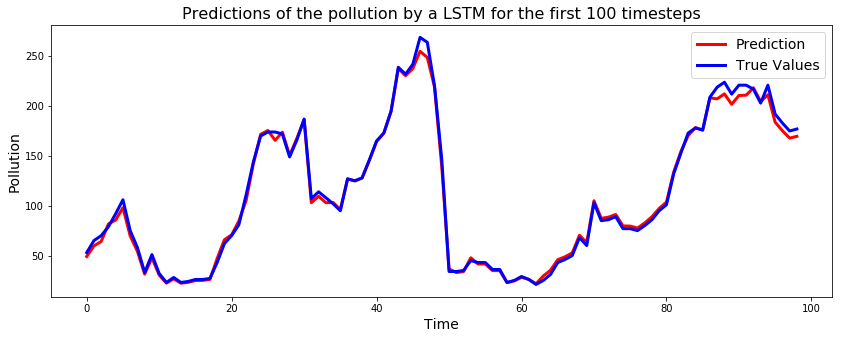

In [151]:
plt.figure(figsize=(14, 5))
plt.plot(uNpred[1:100,0],'-r',lw=3, label='Prediction')
plt.plot(uN_test_y[:99,0],'-b',lw=3,label='True Values')
plt.legend(fontsize=14)
plt.title('Predictions of the pollution by a LSTM for the first 100 timesteps', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Pollution', fontsize=14)
plt.show()

***Comments: *** Graphically the predicted values are really close to the true values. However, if you look carefully to the plot codes, there is a 1-shift on the predicted values indexes. Indeed when doing our first plot, the displays were sensibily the same but with a shift between them. Unfortunetaly, we didn't managed to understand the reason of this shift. In fact, we first thought that it corresponded to the timelag but as we noticed further in the notebook it is linked to the timelag but not directly: sometimes the shift is on predicted values, sometimes on trues values with a value different of the timelag.

In [210]:
#Let's compute the RMSE of this prediction and trues values
def compute_rmse(prediction,shift_test,shift_pred):   #the shift variables are used because further in the notebook
                                                      # we have noticed that there is sometimes a shift between 
                                                      # prediction index and true values index
    sum=0
    n= prediction.shape[0]-shift_test-shift_pred
    for i in range(n):
        sum+=(uN_test_y[i+shift_test,0] - prediction[i+shift_pred,0])**2
    sum = sum/n
    rmse= np.sqrt(sum)
    return rmse

In [155]:
rmse1=compute_rmse(uNpred,0,1)
print('The RMSE for a LSTM prediction model is %s' %rmse1)

The RMSE for a LSTM prediction model is 4.8560694089


***Comments: *** Considering that we predict 8759 values which can somtimes be close to 250, this RMSE seems good as it is not too far from zéro. It means, as we saw graphically, that the predictions are pretty close to the trues values.

In [108]:
#RNN model with the best parameters 

model_rnn1 = Sequential()
model_rnn1.add(SimpleRNN(best1['hdim'],input_shape=input_shape))  
model_rnn1.add(Dense(1, activation='linear'))
model_rnn1.compile(loss='mae', optimizer='adam')

model_rnn1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_15 (SimpleRNN)    (None, 128)               17536     
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 129       
Total params: 17,665
Trainable params: 17,665
Non-trainable params: 0
_________________________________________________________________


In [120]:
batch_size = 64
epochs = 50
history = model_rnn1.fit(train_X, train_y, 
                         epochs = epochs, 
                         batch_size = batch_size, 
                         validation_data=(test_X, test_y), 
                         verbose=1)

Train on 35040 samples, validate on 8759 samples
Epoch 1/50
35040/35040 [==============================] - 12s 332us/step - loss: 0.0230 - val_loss: 0.0146
Epoch 2/50
35040/35040 [==============================] - 4s 110us/step - loss: 0.0144 - val_loss: 0.0151
Epoch 3/50
35040/35040 [==============================] - 4s 118us/step - loss: 0.0145 - val_loss: 0.0150
Epoch 4/50
35040/35040 [==============================] - 4s 112us/step - loss: 0.0145 - val_loss: 0.0203
Epoch 5/50
35040/35040 [==============================] - 4s 117us/step - loss: 0.0144 - val_loss: 0.0131
Epoch 6/50
35040/35040 [==============================] - 4s 121us/step - loss: 0.0143 - val_loss: 0.0133
Epoch 7/50
35040/35040 [==============================] - 4s 113us/step - loss: 0.0146 - val_loss: 0.0125
Epoch 8/50
35040/35040 [==============================] - 4s 115us/step - loss: 0.0141 - val_loss: 0.0130
Epoch 9/50
35040/35040 [==============================] - 4s 116us/step - loss: 0.0144 - val_loss: 0.0

In [124]:
RNNpred = model_rnn1.predict(test_X)

#Let's unnormalize them
RNNpred = np.concatenate((RNNpred, test_X0[:,1:]),axis=1)
uRNNpred = scaler.inverse_transform(RNNpred) #unNormalized prediction(first column)

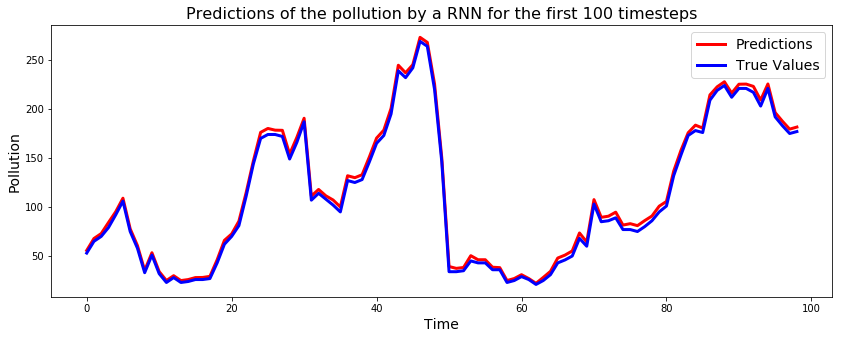

In [126]:
plt.figure(figsize=(14, 5))
plt.plot(uRNNpred[1:100,0],'-r',lw=3, label='Predictions')
plt.plot(uN_test_y[:99,0],'-b',lw=3,label='True Values')
plt.legend(fontsize=14)
plt.title('Predictions of the pollution by a RNN for the first 100 timesteps', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Pollution', fontsize=14)
plt.show()

***Comments: *** Graphically the RNN model looks more effecient than the LSTM which is suprising. Back in the beginning when we represented the MAE of these two models, the LSTM which has more parameters seemed to be more efficient.

In [156]:
#Let's compute the RMSE of this prediction and the true values
rmse2=compute_rmse(uRNNpred)
print('The RMSE for a LSTM prediction model is %s' %rmse2)

The RMSE for a LSTM prediction model is 3.09680255908


***Comments: *** This RMSE is inferior to LSTM's which confirms the graphical interpretation. The predictions here seem better.

In [225]:
#here we gonna assed the impact af timelag on a RNN model

i=6
print('The timelag is %s' %i)
processed_data = build_dataset(scaled, i , 1)
values0 = processed_data.values
values_i= values0.copy()   
values_i[:,-1],values_i[:,-8]=values0[:,-8],values0[:,-1 ]

train_i = values_i[:n_train_hours, :]
test_i = values_i[n_train_hours:, :]
train_Xi, train_yi = train_i[:, :-8], train_i[:, -1]
test_Xi, test_yi = test_i[:, :-8], test_i[:, -1]

train_Xi = train_Xi.reshape((train_Xi.shape[0], 1, train_Xi.shape[1]))
test_Xi = test_Xi.reshape((test_Xi.shape[0], 1, test_Xi.shape[1]))

test_Xi0 = test_Xi.reshape((test_Xi.shape[0],test_Xi.shape[2]))

in_shape = (train_Xi.shape[1], train_Xi.shape[2])
model_rnni=new_rnn(32, in_shape)
model_rnni.fit(train_Xi, train_yi,
                         batch_size=batch_size,
                         epochs=epochs,
                         verbose=1,
                         validation_data=(test_Xi, test_yi))
pred = model_rnni.predict(test_Xi)
pred0 = np.concatenate((pred, test_Xi0[:,-7:]),axis=1)
upred = scaler.inverse_transform(pred0)


The timelag is 6
Train on 35040 samples, validate on 8754 samples
Epoch 1/50
35040/35040 [==============================] - 16s 458us/step - loss: 0.0349 - val_loss: 0.0205
Epoch 2/50
35040/35040 [==============================] - 4s 125us/step - loss: 0.0201 - val_loss: 0.0166
Epoch 3/50
35040/35040 [==============================] - 5s 133us/step - loss: 0.0179 - val_loss: 0.0187
Epoch 4/50
35040/35040 [==============================] - 5s 128us/step - loss: 0.0177 - val_loss: 0.0162
Epoch 5/50
35040/35040 [==============================] - 4s 125us/step - loss: 0.0170 - val_loss: 0.0143
Epoch 6/50
35040/35040 [==============================] - 4s 126us/step - loss: 0.0168 - val_loss: 0.0168
Epoch 7/50
35040/35040 [==============================] - 4s 123us/step - loss: 0.0163 - val_loss: 0.0146
Epoch 8/50
35040/35040 [==============================] - 4s 125us/step - loss: 0.0159 - val_loss: 0.0188
Epoch 9/50
35040/35040 [==============================] - 4s 127us/step - loss: 0.015

***Comments on the code above: *** We wanted to assess how the timelags would impact the RMSE. We've tried a "For" loop when we still believed that the shifts between the indexes - that we mentionned before - was the timelag. Unfortunately, it yielded unlogical results with RMSE reaching very high values. Thus we understood that the link with timelag existed by was not immediate. This is why we computed and represented them one by one to see where the shift was an its value.

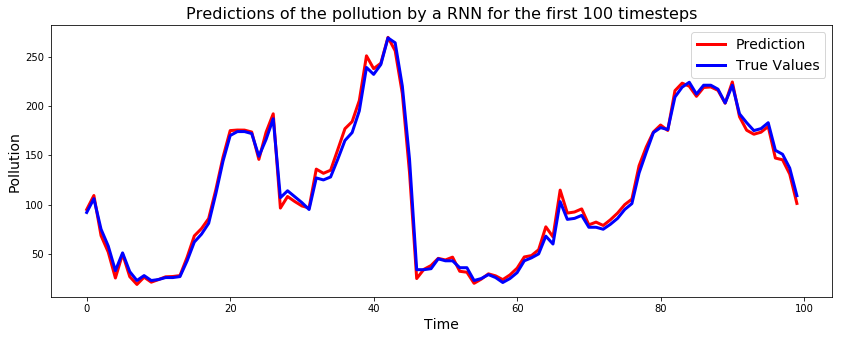

In [227]:
plt.figure(figsize=(14, 5))
plt.plot(upred[0:100,0],'-r',lw=3, label='Prediction')
plt.plot(uN_test_y[4:104,0],'-b',lw=3,label='True Values')
plt.legend(fontsize=14)
plt.title('Predictions of the pollution by a RNN for the first 100 timesteps', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Pollution', fontsize=14)
plt.show()

In [228]:
T.append(compute_rmse(upred,4,0))
T  #this table contains the RMSE for the lag in [1,6]

[3.0968025590761448,
 6.4041375395116562,
 5.8671694275448152,
 5.0468132526796179,
 5.0972678108920455,
 5.7132031669443437]

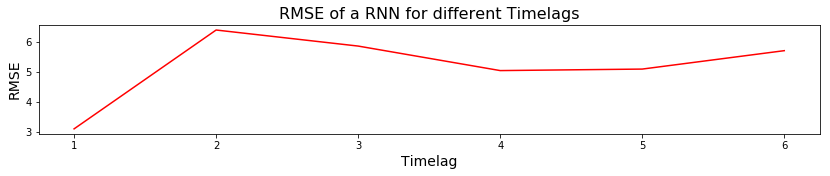

In [234]:
plt.figure(figsize=(14, 2))
plt.plot(np.arange(1,7,1),T,'-r')
plt.title('RMSE of a RNN for different Timelags', fontsize=16)
plt.xlabel('Timelag', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.show()

***Comments: *** It appears that there is not a simple link between the timelag and the efficiency of the model and this is certainly due to the randomness of predictions. However, the best RMSE value which correspond to a timelag of 1 had never been reached again. We think that this has a reason: as the training_X correspond to climate variables, it's hard to neglect the fact that from a hour to another theses variables are somehow linked. Therefore, adding previous measurements in the X training doesn't necessarily bring more information.

In [252]:
#Let's analyze the sensitivity of a LSTM to initialization
T1=[]
for k in range(9):
    lstm0=new_lstm(32,in_shape=input_shape)
    batch_size = 64
    epochs = 50
    history = lstm0.fit(train_X, train_y, 
                         epochs = epochs, 
                         batch_size = batch_size, 
                         validation_data=(test_X, test_y), 
                         verbose=1)
    Npredi = lstm0.predict(test_X) 
    Npredi = np.concatenate((Npredi, test_X0[:,1:]),axis=1)
    uNpredi = scaler.inverse_transform(Npredi)
    T1.append(compute_rmse(uNpredi,0,1))
    print(T1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_46 (LSTM)               (None, 32)                5248      
_________________________________________________________________
dense_102 (Dense)            (None, 1)                 33        
Total params: 5,281
Trainable params: 5,281
Non-trainable params: 0
_________________________________________________________________
Train on 35040 samples, validate on 8759 samples
Epoch 1/50
35040/35040 [==============================] - 20s 570us/step - loss: 0.0251 - val_loss: 0.0130
Epoch 2/50
35040/35040 [==============================] - 6s 174us/step - loss: 0.0138 - val_loss: 0.0125
Epoch 3/50
35040/35040 [==============================] - 6s 162us/step - loss: 0.0138 - val_loss: 0.0128
Epoch 4/50
35040/35040 [==============================] - 5s 154us/step - loss: 0.0136 - val_loss: 0.0125
Epoch 5/50
35040/35040 [==============================] - 6s 1

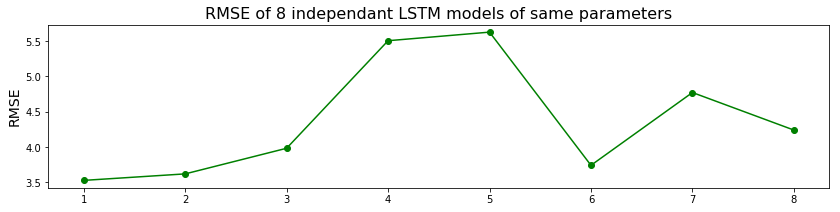

In [258]:
plt.figure(figsize=(14, 3))
plt.plot(np.arange(1,len(T1)+1,1),T1,'o-g')
plt.title('RMSE of %s independant LSTM models of same parameters'%len(T1), fontsize=16)
plt.ylabel('RMSE', fontsize=14)
plt.show()

***Comments: *** With fixed parameters, we can see that independant LSTM models do not have the same performance. There are some variantions of the RMSE values even if they are not drastic: the model depends on the parameters initialization. Perhaps increasing for instance the number of epochs would lead to a convergence of the RMSE as there will be more parameters updates which would eventualy uniformized them indepedently of the initialization.

**Question (bonus)**

How would you capture the randomness of the prediction instead of producing a unique prediction at each time step ?

***Answer: ***At each time step we can do a bunch of predictions and take the mean of thoses predictions as the predicted value.